In [1]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import cPickle as pickle
import data_generator as dg
import multiscale_detect as md
import kmeansutil as ku
import nonmaxsupp as nms
import utils as ut
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

Data is stored in a pickled zipped list of features and labels

In [13]:
#get positive images, determine best ratios (rows over columns), assign to images

pimages = dg.getImagesFromJSON(open("labels.json").read())
print len(pimages)

270


Get negative images

In [14]:
nimages = dg.getRandomMultiple("sun_images", 200, 0)
partialsignimgs = dg.getRandomMultiple("partial", 200, 0)
nimages = nimages+partialsignimgs
nimages = [x[1] for x in nimages]

print len(nimages)


400


Generate features from HOGs and images for each label and aspect ratio

In [15]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


In [16]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 2.1e-1
gammaCorrection = 0
nlevels = 64

dims = (80,80)

hog = cv2.HOGDescriptor(dims,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [17]:
pdata = getFeaturesWithLabel(pimages, hog, dims, 1)
ndata = getFeaturesWithLabel(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))


In [18]:
train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])


Train classifier

In [37]:
lsvm = svm.SVC(gamma=5, C=.1, kernel="linear", probability=True)
lsvm.fit(train_feat, train_label)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [38]:
print lsvm.score(train_feat, train_label)

0.996268656716


Compute and display test set accuracy, true and false positives, true and false negatives, list of files that were misclassified

In [39]:
#compute test accuracy
result = lsvm.predict(test_feat)
print "test accuracy ", lsvm.score(test_feat, test_label)
ut.printConfusionMatrix(result, test_label)




test accuracy  0.962686567164
true pos: 51 true neg: 78 false pos: 0 false neg: 5 



In [40]:
def getHardNegativeFeatures(lsvm, hog, imgDir, step=1, scale=1.1):
    #get dataset of negative images to scan through
    negFiles = dg.getAllFiles(imgDir)
    negImgs = []
    falsePos_feat = []
    signs = 0
    nosigns = 0

    for f in negFiles:
        negImgs.append([f, cv2.imread(imgDir + "/" + f)])
    
    if len(negImgs) == 0:
        raise "No images found"

    #multiscale detect
    for row in negImgs:
        scales = md.pyramid(row[1], scale, minSize=(30, 30))
        winw = hog.winSize[1]
        winh = hog.winSize[0]

        for img in scales:
            results = []

            for (x, y, window) in md.sliding_window(img, step, (winw, winh)):        
                if window.shape[0] != winh or window.shape[1] != winw:
                    continue
                window = cv2.resize(window, (winh, winw))
                feat = hog.compute(window)
                result = lsvm.predict(feat.reshape(1,-1))
                if result == 1:  
                    falsePos_feat.append(feat)
                    signs +=1
                else:
                    nosigns+=1

    falsePosFeat = [x.flatten() for x in falsePos_feat] 
    return falsePosFeat

In [41]:
hardNeg = getHardNegativeFeatures(lsvm, hog, "hwy_empty", step=60, scale=1.5)
print "number of false positives for classifiers", len(hardNeg)

number of false positives for classifiers 417


In [42]:
#retrain classifiers
hNLabels = [0] * len(hardNeg)

if hardNeg:
    train_features_wfp = np.r_[train_feat, np.array(hardNeg)]
    train_labels_wfp = np.r_[train_label, np.array(hNLabels)]
    lsvm.fit(train_features_wfp, train_labels_wfp)
    print "retraining accuracy", lsvm.score(train_features_wfp, train_labels_wfp)
    result = lsvm.predict(test_feat)
    print "retrain test accuracy", lsvm.score(test_feat, test_label)
    ut.printConfusionMatrix(result, test_label)


retraining accuracy 0.995802728227
retrain test accuracy 0.977611940299
true pos: 53 true neg: 78 false pos: 0 false neg: 3 



Find and display signs in a test image

In [43]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

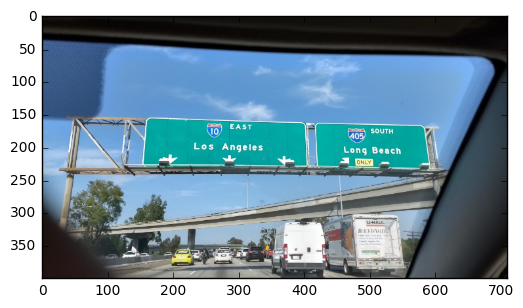

In [378]:
im = cv2.imread("lafwy/la2.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

Preprocess image, get regions of interest bounding boxes using contours, color filtering, thresholding

In [379]:
def preprocess(image, (lower, upper)):

    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    
    #apply smoothing
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(image,-1,kernel)

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask

24864564 34337810 39513982
0.336681931835


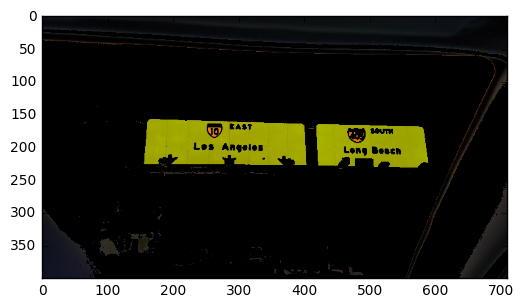

In [380]:
r = np.matrix(im[:,:,2]).sum()
b = np.matrix(im[:,:,0]).sum()
g = np.matrix(im[:,:,1]).sum()
print r, g, b
red_ratio = float(r)/(b+g)
print red_ratio
red_val = int(red_ratio * 120)
pimage, mask = preprocess(im,  ([0,0,0], [255, 255, red_val]))
plt.imshow(pimage)
plt.show()

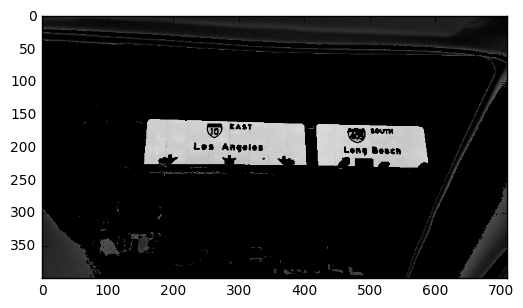

In [381]:
imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

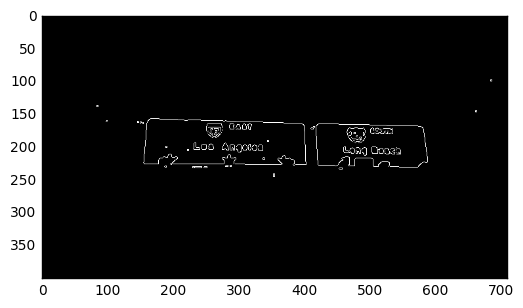

In [382]:
flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
edges = cv2.Canny(binaryImage, 50, 150)
plt.imshow(edges, cmap='gray')
plt.show()

In [383]:
im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

119
5


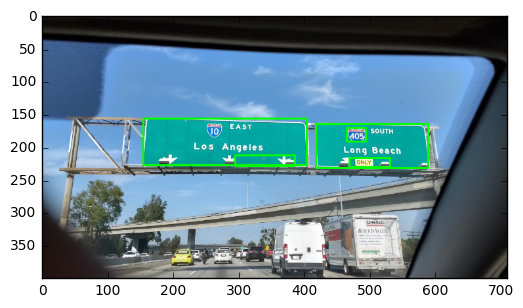

In [384]:
copy = im.copy()
rgb = rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print len(boxes)
boxes2 = [b for b in boxes if b[2]*b[3] > 400]
print len(boxes2)

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

Apply HOG to bounding boxes for result

In [385]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

In [386]:
real_signs = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = im[y:y+h, x:x+w, :]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_signs.append((x,y,w,h))
    
print len(real_signs)


2


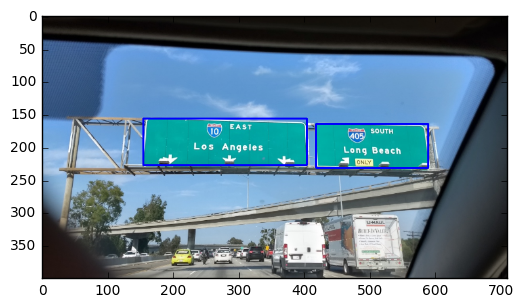

In [387]:
clone = im.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for x, y, w, h in real_signs:
     

    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[3], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()